In [1]:
## load pretrained weights and perform BN folding + quantization
import torch
import numpy as np
from math import sqrt

## define path for model and data
out_dir = './content' ###

### params definition
T = 400
M = 200
num_heads = 4
head_dim = 16
usebias = False
usebn = True
quant = True
integer = True
epsilon = 1e-05

def BN_folding(weights_net, bias_net, weights_bn, bias_bn, mean_bn, var_bn, usebias, usebn, quant):
  weights = weights_net.clone().squeeze()
  if (usebias or usebn):
    bias = bias_net
  if usebn:
    for i in range(weights.shape[0]): # offline folding of BN params into linear params (updated  weights and bias can be saved and used on hardware as regular params of linear)
      weights[i] = weights[i]*weights_bn[i]/sqrt(epsilon+var_bn[i])
      bias[i] = weights_bn[i]*(bias[i]-mean_bn[i])/sqrt(epsilon+var_bn[i]) + bias_bn[i]
  if quant:
    max_value = weights.max().item()
    min_value = weights.min().item()
    layer_scale = 127 / max(max_value, -min_value)
    weights = weights * layer_scale
    weights = weights.round()
    weights = weights/layer_scale
    if usebias or usebn:
      bias = bias * layer_scale
      bias = bias.round()
      bias = bias/layer_scale
    return weights, bias, layer_scale


# Load saved input and partial output vectors for comparison
#embedding_in = np.load(out_dir+'/embedding_in_T_B_N_C.npy')

# Load network model and weights of dense and BN layers within attention
checkpoint = torch.load(out_dir+'/T400_M200residual.pth',map_location='cpu')
weights_emb_proj = checkpoint['net']['patch_embed.proj_dense.weight']
weights_emb_rpe = checkpoint['net']['patch_embed.rpe_dense.weight']
q_linear_w = checkpoint['net']['block.0.attn.q_linear.weight']
k_linear_w = checkpoint['net']['block.0.attn.k_linear.weight']
v_linear_w = checkpoint['net']['block.0.attn.v_linear.weight']
proj_linear_w = checkpoint['net']['block.0.attn.proj_linear.weight']
weights_mlp1 = checkpoint['net']['block.0.mlp.fc1.weight']
weights_mlp2 = checkpoint['net']['block.0.mlp.fc2.weight']
weights_class = checkpoint['net']['classifier_fc.weight']

if usebias:
    bias_emb_proj = torch.zeros(64)
    bias_emb_rpe = torch.zeros(64)
    #bias_emb_proj = checkpoint['net']['patch_embed.proj_dense.bias']
    #bias_emb_rpe = checkpoint['net']['patch_embed.rpe_dense.bias']
    q_linear_b = checkpoint['net']['block.0.attn.q_linear.bias']
    k_linear_b = checkpoint['net']['block.0.attn.k_linear.bias']
    v_linear_b = checkpoint['net']['block.0.attn.v_linear.bias']
    proj_linear_b = checkpoint['net']['block.0.attn.proj_linear.bias']
    #bias_mlp1 = checkpoint['net']['block.0.mlp.fc1.bias']
    #bias_mlp2 = checkpoint['net']['block.0.mlp.fc2.bias']
    #bias_class = checkpoint['net']['classifier_fc.bias']
    bias_mlp1 = torch.zeros(128)
    bias_mlp2 = torch.zeros(64)
    bias_class = torch.zeros(13)
if usebn:
    w_emb_proj_bn = checkpoint['net']['patch_embed.proj_bn.weight']
    b_emb_proj_bn = checkpoint['net']['patch_embed.proj_bn.bias']
    mean_emb_proj_bn = checkpoint['net']['patch_embed.proj_bn.running_mean']
    var_emb_proj_bn = checkpoint['net']['patch_embed.proj_bn.running_var']
    w_emb_rpe_bn = checkpoint['net']['patch_embed.rpe_bn.weight']
    b_emb_rpe_bn = checkpoint['net']['patch_embed.rpe_bn.bias']
    mean_emb_rpe_bn = checkpoint['net']['patch_embed.rpe_bn.running_mean']
    var_emb_rpe_bn = checkpoint['net']['patch_embed.rpe_bn.running_var']
    q_linear_w_bn = checkpoint['net']['block.0.attn.q_bn.weight']
    q_linear_b_bn = checkpoint['net']['block.0.attn.q_bn.bias']
    q_linear_mean_bn = checkpoint['net']['block.0.attn.q_bn.running_mean']
    q_linear_var_bn = checkpoint['net']['block.0.attn.q_bn.running_var']
    k_linear_w_bn = checkpoint['net']['block.0.attn.k_bn.weight']
    k_linear_b_bn = checkpoint['net']['block.0.attn.k_bn.bias']
    k_linear_mean_bn = checkpoint['net']['block.0.attn.k_bn.running_mean']
    k_linear_var_bn = checkpoint['net']['block.0.attn.k_bn.running_var']
    v_linear_w_bn = checkpoint['net']['block.0.attn.v_bn.weight']
    v_linear_b_bn = checkpoint['net']['block.0.attn.v_bn.bias']
    v_linear_mean_bn = checkpoint['net']['block.0.attn.v_bn.running_mean']
    v_linear_var_bn = checkpoint['net']['block.0.attn.v_bn.running_var']
    proj_linear_w_bn = checkpoint['net']['block.0.attn.proj_bn.weight']
    proj_linear_b_bn = checkpoint['net']['block.0.attn.proj_bn.bias']
    proj_linear_mean_bn = checkpoint['net']['block.0.attn.proj_bn.running_mean']
    proj_linear_var_bn = checkpoint['net']['block.0.attn.proj_bn.running_var']
    w_mlp1_bn = checkpoint['net']['block.0.mlp.bn1.weight']
    b_mlp1_bn = checkpoint['net']['block.0.mlp.bn1.bias']
    mean_mlp1_bn = checkpoint['net']['block.0.mlp.bn1.running_mean']
    var_mlp1_bn = checkpoint['net']['block.0.mlp.bn1.running_var']
    w_mlp2_bn = checkpoint['net']['block.0.mlp.bn2.weight']
    b_mlp2_bn = checkpoint['net']['block.0.mlp.bn2.bias']
    mean_mlp2_bn = checkpoint['net']['block.0.mlp.bn2.running_mean']
    var_mlp2_bn = checkpoint['net']['block.0.mlp.bn2.running_var']
    w_class_bn = checkpoint['net']['classifier_bn.weight']
    b_class_bn = checkpoint['net']['classifier_bn.bias']
    mean_class_bn = checkpoint['net']['classifier_bn.running_mean']
    var_class_bn = checkpoint['net']['classifier_bn.running_var']

    if usebias == False:
        bias_emb_proj = torch.zeros(64)
        bias_emb_rpe = torch.zeros(64)
        q_linear_b = torch.zeros(64)
        k_linear_b = torch.zeros(64)
        v_linear_b = torch.zeros(64)
        proj_linear_b = torch.zeros(64)
        bias_mlp1 = torch.zeros(128)
        bias_mlp2 = torch.zeros(64)
        bias_class = torch.zeros(13)

    scale = 0.125
    int_scale = 1/scale
    weights0, bias0, layer_scale0 = BN_folding(weights_emb_proj, bias_emb_proj, w_emb_proj_bn, b_emb_proj_bn, mean_emb_proj_bn, var_emb_proj_bn, usebias, usebn, quant)
    decay0 = torch.tensor(0.5)
    threshold0 = torch.tensor(1)
    weights1, bias1, layer_scale1 = BN_folding(weights_emb_rpe, bias_emb_rpe, w_emb_rpe_bn, b_emb_rpe_bn, mean_emb_rpe_bn, var_emb_rpe_bn, usebias, usebn, quant)
    decay1 = torch.tensor(0.5)
    threshold1 = torch.tensor(1)
    weightsQ, biasQ, layer_scaleQ = BN_folding(q_linear_w, q_linear_b, q_linear_w_bn, q_linear_b_bn, q_linear_mean_bn, q_linear_var_bn, usebias, usebn, quant)
    decayQ = torch.tensor(0.5)
    thresholdQ = torch.tensor(1)
    weightsK, biasK, layer_scaleK = BN_folding(k_linear_w, k_linear_b, k_linear_w_bn, k_linear_b_bn, k_linear_mean_bn, k_linear_var_bn, usebias, usebn, quant)
    decayK = torch.tensor(0.5)
    prev_stateK = torch.tensor(0.0)
    thresholdK = torch.tensor(1)
    weightsV, biasV, layer_scaleV = BN_folding(v_linear_w, v_linear_b, v_linear_w_bn, v_linear_b_bn, v_linear_mean_bn, v_linear_var_bn, usebias, usebn, quant)
    decayV = torch.tensor(0.5)
    #prev_stateV = torch.tensor(0.0)
    thresholdV = torch.tensor(1)
    decay_attn = torch.tensor(0.5)
    prev_state_attn = torch.tensor(0.0)
    threshold_attn = torch.tensor(1)
    layer_scale_attn = 1
    weightsO, biasO, layer_scaleO = BN_folding(proj_linear_w, proj_linear_b, proj_linear_w_bn, proj_linear_b_bn, proj_linear_mean_bn, proj_linear_var_bn, usebias, usebn, quant)
    decayO = torch.tensor(0.5)
    prev_stateO = torch.tensor(0.0)
    thresholdO = torch.tensor(1)
    weightsM1, biasM1, layer_scaleM1 = BN_folding(weights_mlp1, bias_mlp1, w_mlp1_bn, b_mlp1_bn, mean_mlp1_bn, var_mlp1_bn, usebias, usebn, quant)
    decayM1 = torch.tensor(0.5)
    prev_stateM1 = torch.tensor(0.0)
    thresholdM1 = torch.tensor(1)
    weightsM2, biasM2, layer_scaleM2 = BN_folding(weights_mlp2, bias_mlp2, w_mlp2_bn, b_mlp2_bn, mean_mlp2_bn, var_mlp2_bn, usebias, usebn, quant)
    decayM2 = torch.tensor(0.5)
    prev_stateM2 = torch.tensor(0.0)
    thresholdM2 = torch.tensor(1)
    weightsC, biasC, layer_scaleC = BN_folding(weights_class, bias_class, w_class_bn, b_class_bn, mean_class_bn, var_class_bn, usebias, usebn, quant)
    decayC = torch.tensor(0.5)
    prev_stateC = torch.tensor(0.0)
    thresholdC = torch.tensor(0.0625)

K_eval = torch.zeros(T, M, num_heads, head_dim)
V_eval = torch.zeros(T, M, num_heads,  head_dim)

/tmp/ipykernel_21353/1392760832.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(out_dir+'/T400_M200residual.pth',map_location='cpu')


In [3]:
from modules.init_mem import matrix_to_parallel_intmem, matrix_to_single_intmem
import os
import json
from modules.utils import write_spikes_to_file, get_output_path, bin_groups_to_hex, write_spikes_to_4files
weights_dir = './weights'
MEM_MAP = {
    "sm1": "1",
    "sm2": "2",
    "intmem1": "4",
    "intmem2": "8",
    "intmem12": "C",
    "output": "F"
}
transactions = []

denseV_outputs = {12: [], 13: [], 14: [], 15: []}
nibble = {12: np.zeros(16, dtype=np.uint8),
          13: np.zeros(16, dtype=np.uint8),
          14: np.zeros(16, dtype=np.uint8),
          15: np.zeros(16, dtype=np.uint8)}
bit_cnt = {12: 0, 13: 0, 14: 0, 15: 0}


In [4]:
############### Spiking Jelly LIF neuron #########################################################

def integrate_jelly (stimolo, decay, threshold = 1): #state, scale,

    spike_seq = torch.zeros_like(stimolo).to(torch.float)
    v_seq = torch.zeros_like(stimolo).to(torch.float)
    v = v_seq[0]
    for t in range(stimolo.shape[0]):
            v = v + (stimolo[t] - v) * decay
            spike = (v >= threshold)#.to(stimolo)
            v = v - spike *v# threshold
            spike_seq[t] = spike
            v_seq[t] = v
    return spike_seq, v, v_seq

################# True integer integration functions ###########################################

def right_shift(x,bits):
    x_sign = 2 * ( x > 0 ) - 1
    return (x_sign * ((x_sign * x) >> bits))

def quantize(input_value, step = 1):
    return torch.round(input_value / step) * step

def integrate (stimolo, decay, state, scale, threshold = None, precision=16):

    if precision == 16:
      data_type = torch.int16
    else:
      data_type = torch.int32
    stimolo = stimolo.to(data_type)
    output_old = (state).to(data_type)
    decay_int = (decay*4096).to(data_type) # rappresentazione 4.12
    output_new = torch.zeros_like(stimolo).to(data_type)
    spikes_new = torch.zeros_like(stimolo).to(data_type)
    output_old_array = torch.zeros_like(stimolo)
    output_old_array[0,:] = output_old

    if threshold is None:
        threshold_int = None
    else:
        threshold_int = (threshold*64).to(data_type) # rappresentazione 10.6

    for i in range(stimolo.shape[0]):
        current = (stimolo[i,:].to(torch.int32)*decay_int*64).to(torch.int32) # rappresentazione 14.18
        
        output_old_decay = (output_old.to(torch.int32)*decay_int).to(torch.int32)  # rappresentazione 14.18
        output_old_shift = (output_old.to(torch.int32) << 12).to(torch.int32)  # rappresentazione 14.18
        output_new[i,:] = right_shift((output_old_shift + current - output_old_decay).to(torch.int32),12).to(data_type)  # rappresentazione 10.6
        if threshold_int is not None:
            if threshold_int > 0:
                if scale != 1:
                  spikes_new[i,:] = output_new[i,:] >= threshold_int
                else:
                  spikes_new[i,:] = output_new[i,:] >= threshold_int
                output_old = output_new[i,:]
                if scale != 1:
                  output_old[output_old >= threshold_int] = 0
                else:
                  output_old[output_old >= threshold_int] = 0
            else:
                output_old = output_new[i,:]
        else:
            output_old = output_new[i,:]

        if i < stimolo.shape[0]-1:
            output_old_array[i+1,:] = output_old.to(data_type)


    return ((output_new).numpy(), spikes_new, output_old_array)


def spike_detection(voltage,threshold):
    return (voltage >= threshold).to(torch.int32)


def axonal_delay_function(spike,delay):

  delayed_spike = np.zeros_like(spike)
  for i in range(spike.shape[1]):
    last_element = spike.shape[0] - delay[i]
    delayed_spike[delay[i]:,i] = spike[0:last_element,i]
  return delayed_spike

In [ ]:
# Integrate with debug options
def integrate2 (stimolo, decay, state, scale, threshold=None,
              precision=16, *, debug=False, tag=""):

    # ----------------------------- setup -----------------------------
    data_type = torch.int16 if precision == 16 else torch.int32
    stimolo   = stimolo.to(data_type)            
    output_old = state.to(data_type)            
    decay_int  = (decay * 4096).to(data_type)    
    output_new = torch.zeros_like(stimolo).to(data_type)  
    spikes_new = torch.zeros_like(stimolo).to(data_type) 
    output_old_array = torch.zeros_like(stimolo)
    output_old_array[0, :] = output_old

    threshold_int = None
    if threshold is not None:
        threshold_int = (threshold * 64).to(data_type)  

    # ------------------------- main loop ----------------------------
    for i in range(stimolo.shape[0]):
        current          = (stimolo[i].to(torch.int32) * decay_int * 64).to(torch.int32)
        output_old_decay = (output_old.to(torch.int32)  * decay_int).to(torch.int32)
        output_old_shift = (output_old.to(torch.int32)  << 12).to(torch.int32)

        p = (output_old_shift + current - output_old_decay).to(torch.int32)          
        output_new[i,:] = right_shift(p,12).to(data_type)  

        # ------------------- SECTION: DEBUG PRINT ------------------
        if debug:
            print(f"\n[{tag}] timestep={i}")
            print("idx | stim | output_old_raw | current | out_old_shift | out_old_dec | p(Q14.18) | out_new(Q10.6)")
            
            stim_flat    = stimolo[i].flatten()
            old_raw_flat = output_old.flatten()
            cur_flat     = current.flatten()
            shift_flat   = output_old_shift.flatten()
            olddec_flat  = output_old_decay.flatten()
            p_flat       = p.flatten()

           
            raw0  = old_raw_flat.item()     if old_raw_flat.numel()==1  else None
            cur0  = cur_flat.item()         if cur_flat.numel()==1     else None
            sh0   = shift_flat.item()       if shift_flat.numel()==1   else None
            od0   = olddec_flat.item()      if olddec_flat.numel()==1  else None
            pv0   = p_flat.item()           if p_flat.numel()==1       else None

            for idx in range(stimolo.shape[1]):
                s   = int(stim_flat[idx].item())
                oraw= raw0 if raw0 is not None else int(old_raw_flat[idx].item())
                c   = cur0 if cur0 is not None else int(cur_flat[idx].item())
                sh  = sh0  if sh0  is not None else int(shift_flat[idx].item())
                od  = od0  if od0  is not None else int(olddec_flat[idx].item())
                pv  = pv0  if pv0  is not None else int(p_flat[idx].item())
                on  = int(output_new[i, idx].item())
                print(f"{idx:2d}  "
                      f"{s:6d} "
                      f"{oraw:14d} "
                      f"{c:8d} "
                      f"{sh:12d} "
                      f"{od:11d} "
                      f"{pv:11d} "
                      f"{on:14d}")
        # -----------------------------------------------------------




        if threshold_int is not None:
            if threshold_int > 0:
                if scale != 1:
                  spikes_new[i,:] = output_new[i,:] >= threshold_int
                else:
                  spikes_new[i,:] = output_new[i,:] >= threshold_int
                output_old = output_new[i,:]
                if scale != 1:
                  output_old[output_old >= threshold_int] = 0
                else:
                  output_old[output_old >= threshold_int] = 0
            else:
                output_old = output_new[i,:]
        else:
            output_old = output_new[i,:]

        if i < stimolo.shape[0]-1:
            output_old_array[i+1,:] = output_old.to(data_type)

    return output_new.numpy(), spikes_new, output_old_array

# Simulate all

### Weights matrix trasformation

In [7]:
weightsO = weightsO[:, torch.arange(weightsO.shape[1]-1, -1, -1)]
weightsM1 = weightsM1[:, torch.arange(weightsM1.shape[1] - 1, -1, -1)]
weightsM2 = weightsM2[:, torch.arange(weightsM2.shape[1] - 1, -1, -1)]
weightsC = weightsC[:, torch.arange(weightsC.shape[1] - 1, -1, -1)]


In [ ]:

def simulate_all(input_inference, num_timesteps=200):
    transactions = []
    
    DEBUG_FPATH = "debug_verification.txt"
    with open(DEBUG_FPATH, "w") as dbg:
        dbg.write("==== NEW RUN ====\n")
   
    prev_lif_output = None

    
    dense1_weights = None
    dense_final_weights = None
    denseK_weights = {}
    denseV_weights = {}
    num_instructions = 26
    
    lif_output_dense1 = None
    lif_output_dense2 = None

    
    denseK_outputs   = {4: [], 5: [], 6: [], 7: []}
    K_eval = torch.zeros(T, M, num_heads, head_dim)
    V_eval = torch.zeros(T, M, num_heads,  head_dim)
    attn_matrix = torch.zeros(T, num_heads, 1, M)
    attnV_matrix = torch.zeros(T, num_heads, 1, head_dim)
    denseV_outputs   = {12: [], 13: [], 14: [], 15: []}
    denseQKV_outputs = {16: [], 17: [], 18: [], 19: []}
    K_hist = torch.empty(num_heads, 0, head_dim, dtype=torch.int16)
    print(f"[DEBUG] init K_hist.shape = {K_hist.shape}")
   
    nibble    = {}
    bit_cnt   = {}

    
    MEM_MAP = {
        "sm1": "1",
        "sm2": "2",
        "intmem1": "4",
        "intmem2": "8",
        "intmem12": "C",
        "output": "F"
    }
    timestep = 0
    if timestep == 0:
        prev_state0 = torch.tensor(0.0)
        prev_state1 = torch.tensor(0.0)
        prev_stateQ = torch.tensor(0.0)
        prev_stateK = torch.tensor(0.0)
        
        prev_stateV = [
            torch.zeros(1, head_dim, dtype=torch.int16)   
            for _ in range(num_heads)                     
        ]
        prev_state_attn = torch.tensor(0.0)
        prev_stateO = torch.tensor(0.0)
        prev_stateM1 = torch.tensor(0.0)
        prev_stateM2 = torch.tensor(0.0)
        prev_stateC = torch.tensor(0.0)

        prev_voltage = (
            prev_state0, prev_state1, prev_stateQ, prev_stateK, prev_stateV,
            prev_state_attn, prev_stateO, prev_stateM1, prev_stateM2, prev_stateC
        )

    for ts in range(num_timesteps):
        op_id = 0
        summed_spikes = None
        input_ts = input_inference[ts, :]  # shape: [32]
        for op_id in range(num_instructions):
            # ----------------- Embedding Layer -----------------
            # Dense Spike-int 1 (Embedding)
            if op_id == 0:
                debug = 0
                current = np.matmul(input_ts, (weights0.transpose(1,0)*layer_scale0).round()) # current computation
                if usebias or usebn:
                    out_emb_proj = current
                else:
                    out_emb_proj = current
                debugl0 = 0 
                prev_state0, spikes_emb_proj_integer,voltage_old = integrate(out_emb_proj, decay0, torch.tensor(prev_state0), layer_scale0, threshold=threshold0*layer_scale0, precision=16)
                if debugl0:
                    spk = spikes_emb_proj_integer.flatten().cpu().numpy().astype(int).tolist()
                    volt = voltage_old.flatten().cpu().numpy().astype(int).tolist()
                    prev = prev_state0.flatten().astype(int).tolist()    
                    print(f"[DEBUG] Embedding spikes    at ts={ts}: {spk}")
                    print(f"[DEBUG] Embedding voltage   at ts={ts}: {volt}")
                    print(f"[DEBUG] Embedding prev_state at ts={ts}: {prev}")
                
                vmax = max(voltage_old.flatten()).to(torch.int32)
                vmin = min(voltage_old.flatten()).to(torch.int32)
                if (vmax>32768) or (vmin<(-32768)):
                    print(f'Embedding 0 maximum voltage is {max(voltage_old.flatten())} {min(voltage_old.flatten())}')


                # Saving the weights:
                if ts == 0:
                    weights0_np = weights0.cpu().numpy() if isinstance(weights0, torch.Tensor) else weights0
                    scaled_weights0 = (weights0_np * layer_scale0).round()
                    
                    path1 = os.path.join(weights_dir, 'INIT_FILE_INTMEM1.txt')
                    path2 = os.path.join(weights_dir, 'INIT_FILE_INTMEM2.txt')
                    
                    matrix_to_parallel_intmem(
                        path1,
                        path2,
                        scaled_weights0,
                        mode="init",      
                        transpose=False,  
                        base_address=0    
                    )
                   

                spikes_list = spikes_emb_proj_integer.flatten().cpu().numpy().astype(int).tolist()
                
                hex_groups = bin_groups_to_hex(spikes_list, group_size=4)

                for hex_val in hex_groups:
                    transactions.append({
                        "ts": ts,
                        "op_id": op_id,
                        "mem": MEM_MAP["sm2"],    
                        "data": hex_val
                    })
                if debug:
                    inp = np.asarray(input_ts).flatten()
                    scaled_w = (weights0.transpose(1, 0) * layer_scale0).round().to(torch.int32).cpu().numpy()
                    with open(DEBUG_FPATH, "a") as dbg:
                        dbg.write(f"\n[DEBUG @ ts={ts}] Input·Weight products per neuron:\n")
                        for j in range(scaled_w.shape[1]):
                            acc = 0
                            dbg.write(f"Neuron {j:03d}:\n")
                            for i in range(scaled_w.shape[0]):
                                x = int(inp[i])
                                w = int(scaled_w[i, j])
                                prod = x * w
                                acc += prod
                                dbg.write(f"  x[{i:03d}]={x:6d} * w[{i:03d},{j:03d}]={w:6d} = {prod:8d}  (sum={acc})\n")
                            dbg.write(f"  TOTAL = {acc}\n\n")
                    with open(DEBUG_FPATH, "a") as dbg:
                        dbg.write("\n[DEBUG] Scaled weights matrix (layer 0):\n")
                        for row_idx, row in enumerate(scaled_weights0):
                            row_str = " ".join(f"{int(val):6d}" for val in row)
                            dbg.write(f"Row {row_idx:03d}: {row_str}\n")
                
    



       
            #Dense Spike-int 2 (Embedding)
            elif op_id == 1:
                current = np.matmul(spikes_emb_proj_integer, (weights1*layer_scale1).round().transpose(1,0))
                if usebias or usebn:
                    out_emb_rpe = current 
                else:
                    out_emb_rpe = current
                # emb rpe spikes produced with lif
                prev_state1, spikes_emb_rpe_integer,voltage_old = integrate(out_emb_rpe, decay1, torch.tensor(prev_state1), layer_scale1, threshold=threshold1*layer_scale1, precision=16)
                #prev_state1, spikes_emb_rpe_integer,voltage_old = integrate(out_emb_rpe, decay1, torch.tensor(0), layer_scale1, threshold=threshold1*layer_scale1, precision=16)

                vmax = max(voltage_old.flatten()).to(torch.int32)
                vmin = min(voltage_old.flatten()).to(torch.int32)
                if (vmax>32768) or (vmin<(-32768)):
                        print(f'Embedding 1 maximum voltage is {max(voltage_old.flatten())} {min(voltage_old.flatten())}')
                
                # Saving the weights:
                if ts == 0:
                    weights1_np = weights1.cpu().numpy() if isinstance(weights1, torch.Tensor) else weights1
                    scaled_weights1 = (weights1_np * layer_scale1).round()

                    path1 = os.path.join(weights_dir, 'INIT_FILE_INTMEM1.txt')
                    path2 = os.path.join(weights_dir, 'INIT_FILE_INTMEM2.txt')

                    matrix_to_parallel_intmem(
                        path1,
                        path2,
                        scaled_weights1,
                        mode="append",
                        transpose=False,
                        base_address=512
                    )
                    # print(f"[INFO] Second layer weights saved to {path1} and {path2}")

                
                spikes_emb_rpe_list = spikes_emb_rpe_integer.flatten().cpu().numpy().astype(int).tolist()
                hex_groups = bin_groups_to_hex(spikes_emb_rpe_list, group_size=4)
                for hex_val in hex_groups:
                    transactions.append({
                        "ts": ts,
                        "op_id": op_id,
                        "mem": MEM_MAP["sm1"],
                        "data": hex_val
                    })

            
            # ----------------- Sum Spike Spike Layer -----------------
            elif op_id == 2:
                input_vector = spikes_emb_rpe_integer + spikes_emb_proj_integer

                summed_spikes = input_vector.flatten() 
                
                grouped_words = []
                for i in range(0, len(summed_spikes), 2):
                    byte1 = int(summed_spikes[i].item()) & 0xFF  
                    byte2 = int(summed_spikes[i+1].item()) & 0xFF if i+1 < len(summed_spikes) else 0
                    word_hex = f"{byte1:02X}{byte2:02X}" 
                    grouped_words.append(word_hex)

                for word_hex in grouped_words:
                    transactions.append({
                        "ts": ts,
                        "op_id": op_id,
                        "mem": MEM_MAP["intmem2"], 
                        "data": word_hex
                    })

            
            
            # ----------------- Attention Layer -----------------
            # ----------------- Dense Int Int Q generation -----------------
            elif op_id == 3:
                current = np.matmul(input_vector, (weightsQ.transpose(1,0)*layer_scaleQ).round())
                if usebias or usebn:
                    queries = current
                else:
                    queries = current
                
                if ts==0:
                    print(f"[INFO]Queries: Current values at ts={ts}: {queries.tolist()}")
                # q spikes produced with lif
                #prev_stateQ, queries_spikes_integer,voltage_old = integrate(queries, decayQ, torch.tensor(0), layer_scaleQ, threshold=thresholdQ*layer_scaleQ, precision=16)
                prev_stateQ, queries_spikes_integer,voltage_old = integrate(queries, decayQ, torch.tensor(prev_stateQ), layer_scaleQ, threshold=thresholdQ*layer_scaleQ, precision=16)
                queries_spikes_integer = queries_spikes_integer.view(num_heads, head_dim)  # shape: [4, 16]


                vmax = max(voltage_old.flatten()).to(torch.int32)
                vmin = min(voltage_old.flatten()).to(torch.int32)
                if (vmax>32768) or (vmin<(-32768)):
                        print(f'Queries maximum voltage is {max(voltage_old.flatten())} {min(voltage_old.flatten())}')
                
                # Saving the weights:
                if timestep == 0:
                    weightsQ_np = weightsQ.cpu().numpy() if isinstance(weightsQ, torch.Tensor) else weightsQ
                    scaled_weightsQ = (weightsQ_np * layer_scaleQ).round()
                    scaled_weightsQ_T = scaled_weightsQ.T.astype(np.int32)
                    init_file = os.path.join(weights_dir, "INIT_FILE_INTMEM1.txt")
                    matrix_to_single_intmem(
                        init_file,
                        scaled_weightsQ_T,
                        mode="append",
                        base_address=7064
                    )
                   

                for head_id in range(num_heads):
                    spikes = queries_spikes_integer[head_id]  # shape: [16]
                    spikes_list = spikes.cpu().numpy().astype(int).tolist()
                    hex_groups = bin_groups_to_hex(spikes_list, group_size=4)
                    for hex_val in hex_groups:
                        transactions.append({
                            "ts": ts,
                            "op_id": op_id,
                            "mem": MEM_MAP["sm1"],
                            "data": hex_val
                        })

                debug = 0
                if debug:
                    inp = np.asarray(input_vector).flatten()
                    scaled_w = (weightsQ.transpose(1, 0) * layer_scaleQ).round().to(torch.int32).cpu().numpy()

                    with open(DEBUG_FPATH, "a") as dbg:
                        dbg.write(f"\n[DEBUG @ ts={ts}] Input·Weight products for QUERIES (layer Q):\n")
                        for j in range(scaled_w.shape[1]):
                            acc = 0
                            dbg.write(f"Neuron {j:03d}:\n")
                            for i in range(scaled_w.shape[0]):
                                x = int(inp[i])
                                w = int(scaled_w[i, j])
                                prod = x * w
                                acc += prod
                                dbg.write(f"  x[{i:03d}]={x:6d} * w[{i:03d},{j:03d}]={w:6d} = {prod:8d}  (sum={acc})\n")
                            dbg.write(f"  TOTAL = {acc}\n\n")

                    with open(DEBUG_FPATH, "a") as dbg:
                        dbg.write("\n[DEBUG] Scaled weights matrix (QUERIES):\n")
                        for row_idx, row in enumerate(scaled_w.transpose()):
                            row_str = " ".join(f"{int(val):6d}" for val in row)
                            dbg.write(f"Row {row_idx:03d}: {row_str}\n")


            
            # ----------------- Dense Int Int K generation -----------------
            elif op_id == 4:
                current = np.matmul(input_vector, (weightsK.transpose(1,0)*layer_scaleK).round())
                if usebias or usebn:
                    keys = current
                else:
                    keys = current
                # k spikes produced with lif
                #prev_stateK, keys_spikes_integer,voltage_old = integrate(keys, decayK, torch.tensor(0), layer_scaleK, threshold=thresholdK*layer_scaleK, precision=16)
                prev_stateK, keys_spikes_integer,voltage_old = integrate(keys, decayK, torch.tensor(prev_stateK), layer_scaleK, threshold=thresholdK*layer_scaleK, precision=16)
                keys_spikes_integer = keys_spikes_integer.reshape(num_heads, 1, head_dim)

                vmax = max(voltage_old.flatten()).to(torch.int32)
                vmin = min(voltage_old.flatten()).to(torch.int32)
                if (vmax>32768) or (vmin<(-32768)):
                        print(f'Keys maximum voltage is {max(voltage_old.flatten())} {min(voltage_old.flatten())}')

                # Saving the weights:
                if ts == 0:
                    weightsK_np = weightsK.cpu().numpy() if isinstance(weightsK, torch.Tensor) else weightsK
                    scaled_weightsK = (weightsK_np * layer_scaleK).round()

                    base_addresses = {0: 9112, 1: 9624, 2: 10136, 3: 10648}
                    init_file = os.path.join(weights_dir, "INIT_FILE_INTMEM1.txt")
                    for head_id in range(num_heads):
                        w_sub = scaled_weightsK[head_id * head_dim : (head_id + 1) * head_dim, :]
                        matrix_to_single_intmem(
                            init_file,
                            w_sub.T,
                            mode="append",
                            base_address=base_addresses[head_id]
                        )
                        # print(f"[INFO] Saved K head {head_id} (op_id={4+head_id}) to {init_file} at base address {base_addresses[head_id]}")

                for head_id in range(num_heads):
                    op_k = 4 + head_id
                    spikes = keys_spikes_integer[head_id, 0]  # shape: [16]
                    spikes_list = spikes.cpu().numpy().astype(int).tolist()
                    hex_groups = bin_groups_to_hex(spikes_list, group_size=4)
                    for hex_val in hex_groups:
                        transactions.append({
                            "ts": ts,
                            "op_id": op_k,
                            "mem": MEM_MAP["sm2"],
                            "data": hex_val
                        })
                    debug = 0
                    if debug:
                        inp = np.asarray(input_vector).flatten()
                        scaled_w = w_sub.T.astype(np.int32)  

                        with open(DEBUG_FPATH, "a") as dbg:
                            dbg.write(f"\n[DEBUG @ ts={ts}] Input·Weight products for KEYS (head {head_id}):\n")
                            for j in range(scaled_w.shape[1]):
                                acc = 0
                                dbg.write(f"Neuron {j:03d}:\n")
                                for i in range(scaled_w.shape[0]):
                                    x = int(inp[i])
                                    w = int(scaled_w[i, j])
                                    prod = x * w
                                    acc += prod
                                    dbg.write(f"  x[{i:03d}]={x:6d} * w[{i:03d},{j:03d}]={w:6d} = {prod:8d}  (sum={acc})\n")
                                dbg.write(f"  TOTAL = {acc}\n\n")

                        with open(DEBUG_FPATH, "a") as dbg:
                            dbg.write(f"\n[DEBUG] Scaled weights matrix (KEYS head {head_id}):\n")
                            for row_idx, row in enumerate(scaled_w.T):
                                row_str = " ".join(f"{int(val):6d}" for val in row)
                                dbg.write(f"Row {row_idx:03d}: {row_str}\n")
                

                K_hist = torch.cat((K_hist, keys_spikes_integer), dim=1)  # shape: [4, ts+1, 16]
                
            
                         
            # ----------------- MatMul Spike Spike Layer -----------------
            elif op_id in [8, 9, 10, 11]:
                head_id = op_id - 8  # da 0 a 3
                op_id = 8 + head_id  

                
                q_vec = queries_spikes_integer[head_id].to(torch.int16).unsqueeze(0)  # [1, 16]
                k_mat = K_hist[head_id].to(torch.int16).T  # [16, M]
                attn = q_vec @ k_mat  # [1, M]
                curr_len = attn.size(1)
                if curr_len < M:
                    padded = torch.zeros(1, M, dtype=attn.dtype, device=attn.device)
                    padded[0, :curr_len] = attn
                    attn = padded
            
                # ---------------------------------------------------------------
                
               
                debug_attn_ts   = 16          
                debug_attn_head = 1           
                #debug_attn      = (ts == debug_attn_ts and head_id == debug_attn_head)
                debug_attn = 0 
                if debug_attn:
                    with open(DEBUG_FPATH, "a") as dbg:
                        dbg.write(
                            f"\n[DEBUG] ATTENTION head={head_id}  ts={ts} "
                            f"(q_vec·k_matᵀ  → attn[1×{ts+1}])\n"
                        )

                        q_np = q_vec.squeeze().cpu().numpy().astype(int)      # [16]
                        k_np = k_mat.cpu().numpy().astype(int)                # [16, ts+1]

                        for t_step in range(ts + 1):                          
                            acc = 0
                            dbg.write(f" dot[{t_step:03d}] = Σ_i q[i]*k[i,{t_step}]\n")
                            for i_dim in range(q_np.shape[0]):              
                                qval = int(q_np[i_dim])
                                kval = int(k_np[i_dim, t_step])
                                prod = qval * kval
                                acc += prod
                                dbg.write(
                                    f"   i={i_dim:02d} : q={qval:3d} * "
                                    f"k={kval:3d} = {prod:6d} "
                                    f"(partial_sum={acc})\n"
                                )
                            dbg.write(f"   ==> attn[{t_step}] = {acc}\n\n")

                        
                        dbg.write(f"[DEBUG]  K matrix (16×{ts+1})\n")
                        for r in range(k_np.shape[0]):
                            row = " ".join(f"{k_np[r,c]:3d}" for c in range(ts+1))
                            dbg.write(f"row{r:02d}: {row}\n")
                        dbg.write("[DEBUG]  q_vec: " +
                                  " ".join(f"{q:3d}" for q in q_np) + "\n")
                
                # ---------------------------------------------------------------

                
                attn_matrix[ts, head_id] = attn

                
                dots = attn[0, :ts + 1]
                dots_list = dots.cpu().numpy().astype(int).tolist()

                group = [0, 0, 0, 0]
                slot = 0
                for val in dots_list:
                    group[slot] = val
                    hex_data = ''.join(f"{x & 0xFF:02X}" for x in group)
                    transactions.append({
                        "ts": ts,
                        "op_id": op_id,
                        "mem": MEM_MAP["intmem12"],
                        "data": hex_data
                    })
                    slot += 1
                    if slot == 4:
                        group = [0, 0, 0, 0]
                        slot = 0



            elif op_id in [12, 13, 14, 15]:
                head_id = op_id - 12
                base_addr = {12: 11160, 13: 11672, 14: 12184, 15: 12696}[op_id]

                if ts == 0:
                    weightsV_np = weightsV.cpu().numpy() if isinstance(weightsV, torch.Tensor) else weightsV
                    scaled_weightsV = (weightsV_np * layer_scaleV).round()
                    w_sub = scaled_weightsV[head_id * head_dim : (head_id + 1) * head_dim, :].transpose(1, 0)  # [64, 16]

                    path = os.path.join(weights_dir, 'INIT_FILE_INTMEM1.txt')
                    matrix_to_single_intmem(
                        path,
                        w_sub,
                        mode="append",
                        base_address=base_addr
                    )
                  

                    nibble[op_id] = np.zeros(16, dtype=np.int8)
                    bit_cnt[op_id] = 0
                    denseV_outputs[op_id] = []

                
                input_np = input_vector[0, 0].cpu().numpy()  # shape [64]
                weights_sub = weightsV[head_id * head_dim : (head_id + 1) * head_dim, :].transpose(1, 0).cpu().numpy()
                current = np.matmul(input_np, (weights_sub * layer_scaleV).round())
               
                scaled_w_sub = (weights_sub * layer_scaleV).round().astype(np.int32)  # [64,16]
                debug_currents= False
                if debug_currents:
                    with open(DEBUG_FPATH, "a") as dbg:
                        dbg.write(f"\n[DEBUG] Prodotti scalari V-head{head_id} (op_id {op_id}) at ts={ts}\n")
                        for j in range(scaled_w_sub.shape[1]):      # 0..15
                            acc = 0
                            dbg.write(f"Neuron {j:02d}:\n")
                            for i in range(scaled_w_sub.shape[0]):  # 0..63
                                x    = int(input_np[i])
                                w    = int(scaled_w_sub[i, j])
                                prod = x * w
                                acc += prod
                                dbg.write(
                                    f"  x[{i:02d}]={x:6d} * "
                                    f"w[{i:02d},{j:02d}]={w:6d} = {prod:10d}  "
                                    f"(sum={acc})\n"
                                )
                            final = int(current[j])
                            dbg.write(f"  -> current[{j:02d}] = {final}\n\n")
                # ---------------------------------------------------------------
                if usebias or usebn:
                    values = current 
                else:
                    values = current

                values = values.reshape(1, -1)  
                values = torch.from_numpy(values).to(torch.int32) 
                
                '''
                prev_stateV, spike_out, voltage_old = integrate(
                    values,
                    decayV,
                    torch.tensor(prev_stateV),
                    layer_scaleV,
                    threshold=thresholdV * layer_scaleV,
                    precision=16
                )

                '''
                out_new, spike_out, voltage_old = integrate2(
                    stimolo = values,
                    decay = decayV,
                    state = prev_stateV[head_id],
                    scale = layer_scaleV,
                    threshold = thresholdV * layer_scaleV,
                    precision=16,
                    debug     = ts==35,
                    tag       = f"V-head{head_id}_ts{ts}"
                )
                prev_stateV[head_id] = prev_stateV[head_id] = torch.from_numpy(out_new).to(torch.int16)


                vmax = max(voltage_old.flatten()).to(torch.int32)
                vmin = min(voltage_old.flatten()).to(torch.int32)
                if (vmax > 32768) or (vmin < -32768):
                    print(f'Values maximum voltage is {vmax} {vmin}')

                spike_vec = spike_out[0][:head_dim].to(torch.int8)
                denseV_outputs[op_id].append(spike_vec.tolist())

                bit_pos = 3 - (bit_cnt[op_id] % 4)
                for col in range(16):
                    mask = (1 << bit_pos)
                    nibble[op_id][col] = (nibble[op_id][col] & ~mask) | (int(spike_vec[col]) << bit_pos)

                for col in range(16):
                    transactions.append({
                        "ts": ts,
                        "op_id": op_id,
                        "mem": MEM_MAP["sm1"],
                        "data": f"{nibble[op_id][col]:X}"
                    })

                bit_cnt[op_id] += 1
                if bit_cnt[op_id] % 4 == 0:
                    nibble[op_id].fill(0)



            elif op_id in [16, 17, 18, 19]:
                head_id = op_id - 16

                
                v_list = denseV_outputs[12 + head_id]
                if len(v_list) == 0:
                    raise ValueError(f"No V vectors found for head {head_id} at ts={ts}")

                
                V_t = torch.stack([torch.tensor(v, dtype=torch.int16) for v in v_list])
                if V_t.ndim == 1:
                    V_t = V_t.unsqueeze(0)  

               
                pad_len = M - V_t.shape[0]
                if pad_len > 0:
                    padding = torch.zeros(pad_len, head_dim, dtype=V_t.dtype)
                    V_t = torch.cat([V_t, padding], dim=0)  # [M, 16]

                
                attn_t = attn_matrix[ts, head_id]          # [1, M]
                attn_int = attn_t.to(torch.int16)          # [1, M]
                V_int = V_t.to(torch.int16)                # [M, 16]
                attnV = attn_int @ V_int                   # [1, 16]

                
                attnV_matrix[ts, head_id] = attnV
                if ts ==4:
                    print(f"[DEBUG] current attnV at ts={ts}, head={head_id}: {attnV.tolist()}")
                
                attnV_tensor = attnV.reshape(1, -1)
                prev_state_attn, spike_vec, voltage_old = integrate2(
                    attnV_tensor,
                    decay_attn,
                    prev_state_attn.clone().detach() if isinstance(prev_state_attn, torch.Tensor) else torch.tensor(prev_state_attn),
                    layer_scale_attn,
                    threshold=threshold_attn * layer_scale_attn,
                    precision=16,
                    debug     = 0,  
                    tag       = "Attnts4"
                )



                
                vmax = max(voltage_old.flatten()).to(torch.int32)
                vmin = min(voltage_old.flatten()).to(torch.int32)
                if (vmax > 32768) or (vmin < -32768):
                    print(f'Attn LIF maximum voltage is {vmax} {vmin}')

                
                spike_vec = spike_vec[0].to(torch.int8)[:head_dim]  # [1, 16] → [16]
                denseQKV_outputs[op_id] = spike_vec.tolist()

               
                hex_groups = bin_groups_to_hex(spike_vec.tolist(), group_size=4)
                for hex_val in hex_groups:
                    transactions.append({
                        "ts": ts,
                        "op_id": op_id,
                        "mem": MEM_MAP["sm2"],
                        "data": hex_val
                    })
                debug = 0
                if debug:
                    with open(DEBUG_FPATH, "a") as dbg:
                        dbg.write(f"\n[DEBUG @ ts={ts}]  Prodotto attn @ V (head {head_id}, op_id {op_id})\n")
                        dbg.write(f"attn_int shape: {attn_int.shape}, V_int shape: {V_int.shape}\n")

                        for j in range(V_int.shape[1]):  # 0..15
                            acc = 0
                            dbg.write(f"Output dim {j:02d} (dot product):\n")
                            for i in range(V_int.shape[0]):  
                                a = int(attn_int[0, i])  
                                v = int(V_int[i, j])     
                                prod = a * v
                                acc += prod
                                dbg.write(
                                    f"  attn[{i:02d}]={a:6d} * "
                                    f"V[{i:02d},{j:02d}]={v:6d} = {prod:10d}  "
                                    f"(sum={acc})\n"
                                )
                            dbg.write(f"  TOTAL = {acc}\n\n")

                        
                        dbg.write(f"[DEBUG @ ts={ts}]  attn_int:\n")
                        attn_str = " ".join(f"{int(val):6d}" for val in attn_int[0])
                        dbg.write(f"{attn_str}\n")

                        dbg.write(f"[DEBUG @ ts={ts}]  V_int (shape {V_int.shape[0]}×{V_int.shape[1]}):\n")
                        for row_idx, row in enumerate(V_int):
                            row_str = " ".join(f"{int(val):6d}" for val in row)
                            dbg.write(f"Row {row_idx:02d}: {row_str}\n")

            
            elif op_id == 20:
                
                spikes_concat = []
                for i in [16, 17, 18, 19]:
                    spikes_concat.extend(denseQKV_outputs[i])
                spikes_concat_np = np.array(spikes_concat, dtype=np.int16)  # shape: [64]

                assert spikes_concat_np.shape[0] == 64, f"Expected 64 inputs, got {spikes_concat_np.shape[0]}"

                
                base_address = 1736
                if ts == 0:
                    weightsO_np = weightsO.cpu().numpy() if isinstance(weightsO, torch.Tensor) else weightsO
                    scaled_weightsO = (weightsO_np * layer_scaleO).round()

                    path1 = os.path.join(weights_dir, "INIT_FILE_INTMEM1.txt")
                    path2 = os.path.join(weights_dir, "INIT_FILE_INTMEM2.txt")

                    matrix_to_parallel_intmem(
                        path1,
                        path2,
                        scaled_weightsO,
                        mode="append",
                        transpose=False,
                        base_address=base_address
                    )
                   
                weightsO_mat = (weightsO.transpose(1, 0) * layer_scaleO).round().cpu().numpy()  # [64, 64]
                current = np.matmul(spikes_concat_np, weightsO_mat)  # [64]
                debug= False
                if debug:
                    print(f"[DEBUG] Current values at ts={ts}: {current.tolist()}")
                
                current_tensor = torch.from_numpy(current.reshape(1, -1)).to(torch.int32)

                prev_stateO, outs_spikes_integer, voltage_old = integrate(
                    current_tensor,
                    decayO,
                    prev_stateO.clone().detach() if isinstance(prev_stateO, torch.Tensor) else torch.tensor(prev_stateO),
                    layer_scaleO,
                    threshold=thresholdO * layer_scaleO,
                    precision=16
                )
                
                vmax = max(voltage_old.flatten()).to(torch.int32)
                vmin = min(voltage_old.flatten()).to(torch.int32)
                if (vmax > 32768) or (vmin < -32768):
                    print(f'Attn Pout maximum voltage is {vmax} {vmin}')

                
                final_spikes = outs_spikes_integer[0].to(torch.uint8).tolist()
                hex_groups = bin_groups_to_hex(final_spikes, group_size=4)

                for hex_val in hex_groups:
                    transactions.append({
                        "ts": ts,
                        "op_id": op_id,
                        "mem": MEM_MAP["sm1"],
                        "data": hex_val
                    })

            elif op_id == 21:
                
                input_vector = input_vector.squeeze() + outs_spikes_integer  # shape: [64]

                
                sum_output = input_vector.view(-1).cpu().numpy().astype(int).tolist()


                for i in range(0, len(sum_output), 2):
                    byte1 = sum_output[i] & 0xFF
                    byte2 = sum_output[i+1] & 0xFF if i+1 < len(sum_output) else 0
                    word_hex = f"{byte1:02X}{byte2:02X}"

                    transactions.append({
                        "ts": ts,
                        "op_id": op_id,
                        "mem": MEM_MAP["intmem1"],  
                        "data": word_hex
                    })

            elif op_id == 22:
                if input_vector is None:
                    raise ValueError("input_vector non inizializzato per op_id == 22")

                base_address = 7096

                if ts == 0:
                    weightsM1_np = weightsM1.cpu().numpy() if isinstance(weightsM1, torch.Tensor) else weightsM1
                    scaled_weightsM1 = (weightsM1_np * layer_scaleM1).round()

                    path = os.path.join(weights_dir, "INIT_FILE_INTMEM2.txt")
                    matrix_to_single_intmem(
                        path,
                        scaled_weightsM1.T,
                        mode="append",
                        base_address=base_address
                    )
                    
                input_np = input_vector.view(-1).cpu().numpy()  # [64]
                weights_sub = (weightsM1.transpose(1, 0) * layer_scaleM1).round().cpu().numpy()  # [64, 64]
                current = np.matmul(input_np, weights_sub)

                debug_products = 0         
                if debug_products:
                    with open(DEBUG_FPATH, "a") as dbg:                        # DEBUG_FPATH = "debug_verification.txt"
                        dbg.write(f"\n[DEBUG @ ts={ts}]  Prodotti scalari MLP1 (op_id 22)\n")
                        for j in range(weights_sub.shape[1]):                  # 0..63
                            acc = 0
                            dbg.write(f"Neuron {j:02d}:\n")
                            for i in range(weights_sub.shape[0]):              # 0..63
                                x = int(input_np[i])
                                w = int(weights_sub[i, j])
                                prod = x * w
                                acc += prod
                                dbg.write(f"  x[{i:02d}]={x:6d} * "
                                        f"w[{i:02d},{j:02d}]={w:6d} = {prod:10d}  "
                                        f"(sum={acc})\n")
                            dbg.write(f"  TOTAL = {acc}\n\n")
                               
                        dbg.write(f"[DEBUG @ ts={ts}]  Matrice pesi MLP1 (shape {weights_sub.shape[0]}×{weights_sub.shape[1]}):\n")
                        for row_idx, row in enumerate(weights_sub):
                            row_str = " ".join(f"{int(val):6d}" for val in row)
                            dbg.write(f"Row {row_idx:02d}: {row_str}\n")

                # 2. Integrate
                current_tensor = torch.from_numpy(current.reshape(1, -1)).to(torch.int32)
                ''' 
                prev_stateM1, spikes_mlp1_integer, voltage_old = integrate(
                    current_tensor,
                    decayM1,
                    torch.tensor(prev_stateM1),
                    layer_scaleM1,
                    threshold=thresholdM1 * layer_scaleM1,
                    precision=16
                )
                '''
                out_new, spikes_mlp1_integer, voltage_old = integrate2(
                    stimolo   = current_tensor,
                    decay     = decayM1,
                    state     = prev_stateM1,                
                    scale     = layer_scaleM1,
                    threshold = thresholdM1 * layer_scaleM1,
                    precision = 16,
                    debug     = 0,
                    tag       = f"MLP1_ts{ts}"
                )
               
                prev_stateM1 = torch.from_numpy(out_new).to(torch.int16)
                vmax = max(voltage_old.flatten()).to(torch.int32)
                vmin = min(voltage_old.flatten()).to(torch.int32)
                if (vmax > 32768) or (vmin < -32768):
                    print(f'MLP1 maximum voltage is {vmax} {vmin}')

               
                spikes = spikes_mlp1_integer[0].to(torch.uint8).tolist()
               
                hex_groups = bin_groups_to_hex(spikes, group_size=4)

                hex_groups = bin_groups_to_hex(spikes, group_size=4)

                for hex_val in hex_groups:
                    transactions.append({
                        "ts": ts,
                        "op_id": op_id,
                        "mem": MEM_MAP["sm2"],
                        "data": hex_val
                    })


            elif op_id == 23:
                if spikes_mlp1_integer is None:
                    raise ValueError("spikes_mlp1_integer non inizializzato per op_id == 23")

                base_address = 2760

                if ts == 0:
                    weightsM2_np = weightsM2.cpu().numpy() if isinstance(weightsM2, torch.Tensor) else weightsM2
                    scaled_weightsM2 = (weightsM2_np * layer_scaleM2).round()

                    path1 = os.path.join(weights_dir, "INIT_FILE_INTMEM1.txt")
                    path2 = os.path.join(weights_dir, "INIT_FILE_INTMEM2.txt")

                    matrix_to_parallel_intmem(
                        path1,
                        path2,
                        scaled_weightsM2,
                        mode="append",
                        transpose=False, 
                        base_address=base_address
                    )
                    

                # 1. Dense layer
                input_np = spikes_mlp1_integer.view(-1).cpu().numpy()  # shape [64]
                weights_mat = (weightsM2.transpose(1, 0) * layer_scaleM2).round().cpu().numpy()  # [64, 128]
                current = np.matmul(input_np, weights_mat)  # [128]
                
              
                debug_products = 0
                if debug_products:
                    with open(DEBUG_FPATH, "a") as dbg:
                        dbg.write(f"\n[DEBUG @ ts={ts}]  Prodotti scalari MLP2 (op_id 23)\n")
                        for j in range(weights_mat.shape[1]):  # 0..127
                            acc = 0
                            dbg.write(f"Neuron {j:03d}:\n")
                            for i in range(weights_mat.shape[0]):  # 0..63
                                x = int(input_np[i])
                                w = int(weights_mat[i, j])
                                prod = x * w
                                acc += prod
                                dbg.write(
                                    f"  x[{i:02d}]={x:6d} * "
                                    f"w[{i:02d},{j:03d}]={w:6d} = {prod:10d}  "
                                    f"(sum={acc})\n"
                                )
                            dbg.write(f"  TOTAL = {acc}\n\n")

                        
                        dbg.write(f"[DEBUG @ ts={ts}]  Matrice pesi MLP2 (shape {weights_mat.shape[0]}×{weights_mat.shape[1]}):\n")
                        for row_idx, row in enumerate(weights_mat):
                            row_str = " ".join(f"{int(val):6d}" for val in row)
                            dbg.write(f"Row {row_idx:02d}: {row_str}\n")
                # ---------------------------------------------------------------

                # 2. LIF integrate
                current_tensor = torch.from_numpy(current.reshape(1, -1)).to(torch.int32) 
                ''' 
                prev_stateM2, spikes_mlp2_integer, voltage_old = integrate(
                    current_tensor,
                    decayM2,
                    torch.tensor(prev_stateM2),
                    layer_scaleM2,
                    threshold=thresholdM2 * layer_scaleM2,
                    precision=16
                )
                '''
                out_new, spikes_mlp2_integer, voltage_old = integrate2(
                    stimolo   = current_tensor,
                    decay     = decayM2,
                    state     = prev_stateM2,               
                    scale     = layer_scaleM2,
                    threshold = thresholdM2 * layer_scaleM2,
                    precision = 16,
                    debug     = ts==36,
                    tag       = f"MLP2_ts{ts}"
                )
                
                prev_stateM2 = torch.from_numpy(out_new).to(torch.int16)

                vmax = max(voltage_old.flatten()).to(torch.int32)
                vmin = min(voltage_old.flatten()).to(torch.int32)
                if vmax > 32768 or vmin < -32768:
                    print(f'MLP2 maximum voltage is {vmax} {vmin}')

                spike_list = spikes_mlp2_integer[0].to(torch.uint8).tolist()
                hex_groups = bin_groups_to_hex(spike_list, group_size=4)

                for hex_val in hex_groups:
                    transactions.append({
                        "ts": ts,
                        "op_id": op_id,
                        "mem": MEM_MAP["sm1"],
                        "data": hex_val
                    })


            elif op_id == 24:
                if input_vector is None:
                    raise ValueError("input_vector non inizializzato per op_id == 24")
                if spikes_mlp2_integer is None:
                    raise ValueError("spikes_mlp2_integer non inizializzato per op_id == 24")

                
                input_vector = input_vector.squeeze() + spikes_mlp2_integer.squeeze()  # shape [64]

                
                sum_output = input_vector.view(-1).cpu().numpy().astype(int).tolist()

                for i in range(0, len(sum_output), 2):
                    byte1 = sum_output[i] & 0xFF
                    byte2 = sum_output[i+1] & 0xFF if i+1 < len(sum_output) else 0
                    word_hex = f"{byte1:02X}{byte2:02X}"

                    transactions.append({
                        "ts": ts,
                        "op_id": op_id,
                        "mem": MEM_MAP["intmem2"], 
                        "data": word_hex
                    })

            elif op_id == 25:
                if input_vector is None:
                    raise ValueError("input_vector non inizializzato per op_id == 25")

                base_address = 13240

                if ts == 0:
                    weightsC_np = weightsC.cpu().numpy() if isinstance(weightsC, torch.Tensor) else weightsC
                    scaled_weightsC = (weightsC_np * layer_scaleC).round()

                    path = os.path.join(weights_dir, "INIT_FILE_INTMEM1.txt")
                    matrix_to_single_intmem(
                        path,
                        scaled_weightsC.T,
                        mode="append",
                        base_address=base_address
                    )
                   
                input_np = input_vector.view(-1).cpu().numpy()  # shape [64]
                weights_mat = (weightsC.transpose(1, 0) * layer_scaleC).round().cpu().numpy()  # [64, 13]
                current = np.matmul(input_np, weights_mat)  # [13]

                
                current_tensor = torch.from_numpy(current.reshape(1, -1)).to(torch.int32)
                prev_stateC, spikes_class_integer, voltage_old = integrate(
                    current_tensor,
                    decayC,
                    torch.tensor(prev_stateC),
                    layer_scaleC,
                    threshold=thresholdC * layer_scaleC,
                    precision=32
                )

                vmax = max(voltage_old.flatten()).to(torch.int32)
                vmin = min(voltage_old.flatten()).to(torch.int32)
                if (vmax > 32768) or (vmin < -32768):
                    print(f'Class LIF maximum voltage is {vmax} {vmin}')

                
                spike_bits = [int(b) for b in spikes_class_integer[0][:13]]  # [13]
                bin_str = ''.join(str(bit) for bit in reversed(spike_bits))  # LSB first
                hex_val = f"{int(bin_str, 2):04X}"  # MSB packed in left

                transactions.append({
                    "ts": ts,
                    "op_id": op_id,
                    "mem": MEM_MAP["output"], 
                    "data": hex_val
                })
           

    return transactions


In [9]:
def new_delta_modulation(input,delta,output):
  prev = np.zeros(input[0].shape)
  for j in range(0,input.shape[0]):
    pos_spike = input[j] > (prev + delta); #print(input[j]);
    neg_spike = input[j] < (prev - delta); #print(prev); print(delta); print('__________________________')
 
    prev[pos_spike] = prev[pos_spike] + delta[pos_spike]
    prev[neg_spike] = prev[neg_spike] - delta[neg_spike]
 
    #output[j] = np.insert(neg_spike, 0, pos_spike, axis=0)
    output[j,0::2] = pos_spike
    output[j,1::2] = neg_spike
 

Tipo segnale raw: float32
Shape: (408, 16)
Valori: -27.0 → 39.0
Quantized range: -88 → 127
✅ Salvato 'raw_input_8bit.txt' con 6400 righe
✅ Salvato delta.txt: [8 9 7 9 9 6 7 7 7 9 8 7 9 6 8 6]
✅ Salvato embedding_in_T_B_N_C.npy con shape: (408, 1, 1, 32)


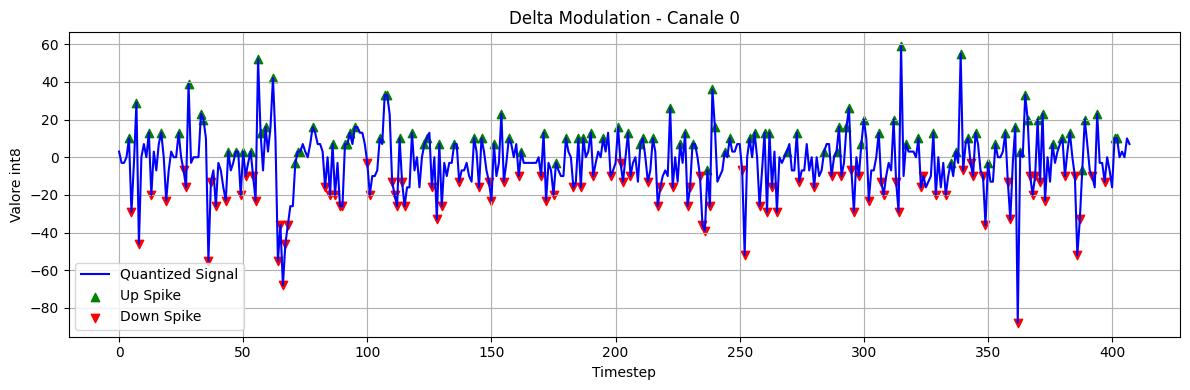


Primi 5 timestep di embedding_in:
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 1.]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

os.makedirs("init", exist_ok=True)
os.makedirs("delta", exist_ok=True)

raw_signal = np.load("content/window/raw_signal_onewindow.npy")  # (T, D)
T, D = raw_signal.shape
assert D == 16, "Atteso segnale con 16 canali"

print("Tipo segnale raw:", raw_signal.dtype)
print("Shape:", raw_signal.shape)
print("Valori:", raw_signal.min(), "→", raw_signal.max())

abs_max = max(abs(raw_signal.min()), abs(raw_signal.max()))
scale = 127.0 / abs_max
quantized = (raw_signal * scale).round().astype(np.int8)
print("Quantized range:", quantized.min(), "→", quantized.max())

quantized_trimmed = quantized[:400]  # (400, 16)

TOTAL_PADDING = 0 
packed_bytes = []


for _ in range(TOTAL_PADDING):
    packed_bytes.append(0)


for t in range(quantized_trimmed.shape[0]):
    for i in range(16):
        value = quantized_trimmed[t, i] & 0xFF
        packed_bytes.append(value)


with open("init/raw_input_8bit.txt", "w") as f:
    for b in packed_bytes:
        f.write(f"{b:02X}\n")

print(f"Salvato 'raw_input_8bit.txt' con {len(packed_bytes)} righe")




np.random.seed(42)
delta_array = np.random.randint(5, 10, size=D)
with open("delta/delta.txt", "w") as f:
    for d in delta_array:
        f.write(f"{d:04X}\n")
print("✅ Salvato delta.txt:", delta_array)

def new_delta_modulation(input, delta, output):
    prev = np.zeros(input[0].shape)
    for j in range(input.shape[0]):
        pos_spike = input[j] > (prev + delta)
        neg_spike = input[j] < (prev - delta)
        prev[pos_spike] += delta[pos_spike]
        prev[neg_spike] -= delta[neg_spike]
        output[j, 0::2] = pos_spike
        output[j, 1::2] = neg_spike

output_spikes = np.zeros((T, D * 2), dtype=np.uint8)
new_delta_modulation(quantized, delta_array, output_spikes)


embedding_in = output_spikes.astype(np.float32).reshape(T, 1, 1, D * 2)
np.save("content/embedding_in_T_B_N_C.npy", embedding_in)
print("✅ Salvato embedding_in_T_B_N_C.npy con shape:", embedding_in.shape)


plt.figure(figsize=(12, 4))
dim = 0
plt.plot(quantized[:, dim], color='blue', label="Quantized Signal")
up = np.where(output_spikes[:, 2*dim] == 1)[0]
down = np.where(output_spikes[:, 2*dim+1] == 1)[0]
plt.scatter(up, quantized[up, dim], marker='^', color='green', label="Up Spike")
plt.scatter(down, quantized[down, dim], marker='v', color='red', label="Down Spike")
plt.title(f"Delta Modulation - Canale {dim}")
plt.xlabel("Timestep")
plt.ylabel("Valore int8")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


print("\nPrimi 5 timestep di embedding_in:")
print(embedding_in[:1, 0, 0, :])


In [ ]:
"""
Costruisce sim/mem/flash.txt secondo la segmentazione a blocchi da 32 768 byte:
- blocco 0 -> INTMEM1
- blocco 1 -> INTMEM2
- blocco 2 -> input buffer (raw_input_8bit.txt)
"""

from pathlib import Path

BLK_SIZE        = 32_768                # 0x8000
BASE_ADDR_OFF   = 0                     
INTMEM1_OFF     = BASE_ADDR_OFF + 0          # blocco 0
INTMEM2_OFF     = BASE_ADDR_OFF + BLK_SIZE   # blocco 1
INPUT_OFF       = BASE_ADDR_OFF + BLK_SIZE*2 # blocco 2

WEIGHTS_DIR     = Path("weights")
INFILE1         = WEIGHTS_DIR / "INIT_FILE_INTMEM1.txt"
INFILE2         = WEIGHTS_DIR / "INIT_FILE_INTMEM2.txt"
RAW_INPUT_FILE  = Path("init/raw_input_8bit.txt")
OUT_FLASH       = Path("sim/mem/flash.txt")

# === Helper ===
def read_words16(path):
    with open(path) as f:
        return [int(l.strip(), 16) & 0xFFFF for l in f if l.strip()]

def words16_to_bytes_be(words):
    """High-byte first (big-endian)"""
    out = []
    for w in words:
        out.append((w >> 8) & 0xFF)  # high byte
        out.append(w & 0xFF)         # low  byte
    return out

def words16_to_bytes_le(words):
    b = bytearray()
    for w in words:
        b += bytes((w & 0xFF, (w >> 8) & 0xFF))   # little-endian
    return b

def read_bytes_per_line(path):
    with open(path) as f:
        return bytes(int(l.strip(), 16) & 0xFF for l in f if l.strip())

def fill_section(dest, offset, data, section_len):
    if len(data) > section_len:
        raise ValueError(f"Sezione troppo piccola ({section_len}) per {len(data)} byte")
    dest[offset:offset+len(data)] = data

image_len = max(INPUT_OFF + 1, BLK_SIZE*2)  
image     = bytearray([0x00]*image_len)


bw1 = words16_to_bytes_be(read_words16(INFILE1))
fill_section(image, INTMEM1_OFF, bw1, BLK_SIZE)

bw2 = words16_to_bytes_be(read_words16(INFILE2))
fill_section(image, INTMEM2_OFF, bw2, BLK_SIZE)

inp = read_bytes_per_line(RAW_INPUT_FILE)
fill_section(image, INPUT_OFF, inp, len(inp))  

OUT_FLASH.parent.mkdir(parents=True, exist_ok=True)
with open(OUT_FLASH, "w") as f:
    for b in image:
        f.write(f"{b:02X}\n")

print(f"Creato {OUT_FLASH} – {len(image):,} byte totali")


✅  Creato sim/mem/flash.txt – 71,936 byte totali


In [12]:
if __name__ == "__main__":
    open("debug_neuron_step.txt", "w").close()

    txns = simulate_all(embedding_in, num_timesteps=200)
    with open("data/golden_txns.json", "w") as f:
        json.dump(txns, f, indent=1)
    print(f"Golden model generated: {len(txns)} transactions")

[DEBUG] init K_hist.shape = torch.Size([4, 0, 16])
[INFO]Queries: Current values at ts=0: [[[-193.0, -52.0, -55.0, -89.0, -6.0, -204.0, 46.0, 88.0, -41.0, -17.0, -76.0, 65.0, 45.0, -164.0, -78.0, -4.0, 40.0, -69.0, 78.0, -206.0, 2.0, -59.0, 41.0, -117.0, -118.0, -59.0, -39.0, 131.0, 23.0, 40.0, -66.0, -18.0, 33.0, -109.0, 96.0, 138.0, 25.0, 81.0, 49.0, -70.0, 151.0, -28.0, 46.0, 125.0, -86.0, -78.0, -214.0, 133.0, -109.0, -78.0, 81.0, 91.0, -204.0, 70.0, -52.0, -52.0, -81.0, -81.0, 67.0, 64.0, -109.0, 35.0, -43.0, 69.0]]]
[DEBUG] current attnV at ts=4, head=0: [[0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0]]
[DEBUG] current attnV at ts=4, head=1: [[0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 2, 1]]
[DEBUG] current attnV at ts=4, head=2: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[DEBUG] current attnV at ts=4, head=3: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


/tmp/ipykernel_21353/2651764173.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prev_state0, spikes_emb_proj_integer,voltage_old = integrate(out_emb_proj, decay0, torch.tensor(prev_state0), layer_scale0, threshold=threshold0*layer_scale0, precision=16)
/tmp/ipykernel_21353/2651764173.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prev_state1, spikes_emb_rpe_integer,voltage_old = integrate(out_emb_rpe, decay1, torch.tensor(prev_state1), layer_scale1, threshold=threshold1*layer_scale1, precision=16)
/tmp/ipykernel_21353/2651764173.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().require

[DEBUG] Current values at ts=21: [[-73, 41, 30, -14, 37, -9, 26, -56, -27, -13, 62, -116, -120, 36, 15, 24, -120, -61, -37, 61, 75, 18, -15, 23, -9, -38, 52, 6, 48, 7, -24, -55, 84, -76, 91, -52, 19, -65, -28, 68, -31, 15, 31, -47, -12, -7, 36, -64, 52, 35, 77, 60, 41, -111, -3, 3, 31, -57, -76, 54, 36, -26, -50, 23]]
[DEBUG] Voltage values at ts=21: [[-1, 0, 0, -1, 0, -1, 0, 0, 0, 0, 1, 0, 0, 0, 0, -1, 0, -1, 0, 0, 0, 0, 1, 0, 0, -1, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, -2, -2, -2, 0, 0, 0, 0, -1, 0, 0, -3, 0, 0, -1, -1, 0, 1, 0, -1, 0, 1, 0, 0, 0, 0, -1, 0]]
[DEBUG] Spikes produced at ts=21: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[DEBUG] Previous state at ts=21: [[-2336, 1312, 960, -448, 1184, -288, 832, -1792, -864, -416, 1984, -3712, -3840, 1152, 480, 767, -3840, -1952, -1184, 1952, 2400, 576, -479, 736, -288, -1216, 1664, 192, 153